In [52]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ------  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                     9KB  2022-10-06 08:55:25           6204        204  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset              11KB  2022-09-30 04:05:11           5045        159  1.0              
akshaydattatraykhare/car-details-dataset                        Car Details Dataset                                 56KB  2022-10-21 06:11:56           1066         29  1.0              
whenamancodes/students-performa

In [53]:
!kaggle datasets download stanfordu/street-view-house-numbers -p ../input/street-view-house-numbers/ --unzip

 99% 2.48G/2.50G [01:05<00:00, 41.5MB/s]
100% 2.50G/2.50G [01:05<00:00, 41.1MB/s]


In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import pandas as pd
import numpy as np
import torch
import scipy.io
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from tqdm import tqdm
from torchvision.models import resnet50, resnet101
from collections import defaultdict
from torch.optim.lr_scheduler import StepLR
from torchvision.ops import nms
from torchvision.datasets import ImageFolder

In [56]:
def get_rect(c_x, c_y, w, h):
    from shapely.geometry import Polygon
    return Polygon([(c_x - w / 2, c_y + h / 2),
                    (c_x + w / 2, c_y + h / 2),
                    (c_x + w / 2, c_y - h / 2),
                    (c_x - w / 2, c_y - h / 2)])

def iou(left, right):
    res = left.intersection(right)
    
    score = res.area / (left.area + right.area - res.area)
    return score

def get_target_masks_sparse(ys, h, w, h_pred, w_pred):
    w_step = w / w_pred
    h_step = h / h_pred
    
    candidate_mapping = {}
    for i in np.arange(0, h, h_step):
        for j in np.arange(0, w, w_step):
            box = get_rect(j + w_step / 2, i + h_step / 2, w_step, h_step)
            for c_x, c_y, w_box, h_box in ys:
                other = get_rect(c_x * w, c_y * h, w_box, h_box)
                score = iou(box, other)
                
                if score > candidate_mapping.get((int(i / h_step), int(j / w_step)), (0.0,))[0]:
                    candidate_mapping[(int(i / h_step), int(j / w_step))] = (score, c_x, c_y, w_box, h_box)
    idxs, vals = list(zip(*candidate_mapping.items()))
    ys, xs = list(zip(*idxs))
    idxs = [list(ys), list(xs)]
    scores, c_xs, c_ys, w_boxes, h_boxes = list(zip(*vals))
    return torch.stack([
        torch.sparse_coo_tensor(idxs, np.ones(len(scores)), size=(h_pred, w_pred)).coalesce(), # target has image
        torch.sparse_coo_tensor(idxs, c_xs, size=(h_pred, w_pred)).coalesce(), # c_xs
        torch.sparse_coo_tensor(idxs, c_ys, size=(h_pred, w_pred)).coalesce(), # c_ys
        torch.sparse_coo_tensor(idxs, w_boxes, size=(h_pred, w_pred)).coalesce(), # w_boxes
        torch.sparse_coo_tensor(idxs, h_boxes, size=(h_pred, w_pred)).coalesce(), # h_boxes
    ])
            

In [57]:
def mat_to_dataset(mat_path):
    import h5py
    f = h5py.File(mat_path, mode='r')
    datasets = {}
    files_count = len(f['digitStruct']['name'])
    for i in range(files_count):
        name_uint16 = f[f['digitStruct']['name'][i,0]][:]
        name = ''.join(chr(n) for n in name_uint16)
        
        bbox = {}
        box_i = f[f['digitStruct']['bbox'][i,0]]
        length = box_i['label'].shape[0]
        for key in ['height', 'label', 'left', 'top', 'width']:
            l = []
            if key=='label':
                l = [ int(str(int(f[box_i[key][index,0]][0][0]))[-1]) if length > 1 else int(box_i[key][0][0]) for index in range(length) ]
            else:
                l = [ int(f[box_i[key][index,0]][0][0]) if length > 1 else int(box_i[key][0][0]) for index in range(length) ]
            bbox[key] = l
        datasets[name] = bbox
        print(f'Loading {i} / {files_count}.\r', end='') 
    print() 
    print(f'{i+1} records loaded.') 
    return datasets

In [58]:
class DetectionDataset(Dataset):
    def __init__(self, image_root_dir, parsed_targets, resize=(500, 500), pred_box_size=(16, 16), mode='train'):
        
        self.transform = Compose([ToTensor(), Resize(resize)])
        
        self.root_name = image_root_dir
        self.images_names = np.array(list(sorted(os.listdir(f'{image_root_dir}/{mode}'))))[:-1]
        self.size = len(self.images_names)
        self.image_folder = ImageFolder(image_root_dir, transform=self.transform)
        self.target_masks = []
        
        
        
        for img_file in tqdm(self.images_names):
            with Image.open(f"{image_root_dir}/{mode}/{img_file}") as im:
                img_w, img_h = im.size
            points = []
            info = parsed_targets[img_file]
            labels, heights, tops, lefts, widths = info['label'], info['height'], info['top'], info['left'], info['width']
            for label, height, top, left, width in zip(labels, heights, tops, lefts, widths):
                scaled_w = width / img_w * resize[0]
                scaled_h = height / img_h * resize[1]
                
                scaled_left = left / img_w * resize[0]
                scaled_top = top/ img_h * resize[1]
                
                c_x = scaled_left  + scaled_w / 2
                c_y = scaled_top + scaled_h / 2
                
                
                
                points.append([c_x / resize[0], c_y / resize[1], scaled_w, scaled_h])
            self.target_masks.append(get_target_masks_sparse(points, *resize, *pred_box_size))
        self.target_masks = torch.stack(self.target_masks)
    
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            idx = list(np.arange(0, self.size)[idx])
        if not isinstance(idx, list):
            idx = [idx]
        items = [self.image_folder[i][0] for i in idx]
        targets = [self.target_masks[i].to_dense() for i in idx]
        return torch.stack(items), torch.stack(targets)

In [ ]:
parsed_targets = mat_to_dataset('../input/street-view-house-numbers/train_digitStruct.mat')

Loading 33401 / 33402.
33402 records loaded.


In [ ]:
dataset = DetectionDataset('../input/street-view-house-numbers/train', parsed_targets)

100%|██████████| 33402/33402 [19:25<00:00, 28.67it/s]


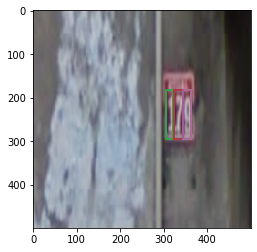

In [ ]:
idx = 50
from matplotlib.patches import Polygon
image = dataset[idx][0][0].permute(1, 2, 0)
img_w, img_h, _ = image.shape
masks_data = dataset.target_masks[idx]

c_xs = (masks_data[1].coalesce().values() * image.shape[1]).tolist()
c_ys = (masks_data[2].coalesce().values() * image.shape[0]).tolist()
ws = masks_data[3].coalesce().values().tolist()
hs = masks_data[4].coalesce().values().tolist()


plt.imshow(image)
h_step = img_h / 32
w_step = img_w / 32
for c_x, c_y, w, h in zip(c_xs, c_ys, ws, hs):
    xs = [c_x - w / 2, c_x + w / 2, c_x + w / 2, c_x - w / 2, c_x - w / 2]
    ys = [c_y + h / 2, c_y + h / 2, c_y - h / 2, c_y - h / 2, c_y + h / 2]
    plt.plot(xs, ys)

In [ ]:
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [60]:
backbone = resnet101(pretrained=True).to(device)
model = nn.Sequential(*list(backbone.children())[:-2],
                     nn.Conv2d(in_channels=2048, out_channels=5, kernel_size=1, stride=1)).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
PATH = '../home/detection-model-SVHN-final.model'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model.train()

for epoch in range(20):
    bar = tqdm(dataloader)
    avg_bce_has_box = 0
    avg_bce_c_x = 0
    avg_bce_c_y = 0
    avg_width_loss = 0
    avg_height_loss = 0
    avg_loss = 0
    step = 0
    for xs, ys in bar:
        optimizer.zero_grad()
        samples = xs.squeeze(1).to(device)
        masks   = ys.squeeze(1).to(device)

        predicts = model(samples)

        sign_proba, c_xs, c_ys, w_pred, h_pred = torch.unbind(predicts, dim=1)
        sign_target, c_xs_target, c_ys_target, w_target, h_target = torch.unbind(masks, dim=1)
        
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        bce_has_box = bce_loss(sign_proba, sign_target).mean()
        bce_c_x = (sign_target * bce_loss(c_xs, c_xs_target)).mean()
        bce_c_y = (sign_target * bce_loss(c_ys, c_ys_target)).mean()
        width_loss = (sign_target * torch.abs(torch.exp(w_pred) - w_target.float())).mean()
        height_loss = (sign_target * torch.abs(torch.exp(h_pred) - h_target.float())).mean()
        loss = 15 * bce_has_box + 1000 * bce_c_x + 1000 * bce_c_y + width_loss + height_loss
        loss.backward()
        optimizer.step()
        
        avg_bce_has_box += bce_has_box.item()
        avg_bce_c_x += bce_c_x.item()
        avg_bce_c_y += bce_c_y.item()
        avg_width_loss += width_loss.item()
        avg_height_loss += height_loss.item()
        avg_loss += loss.item()
        step += 1
        
        bar.set_postfix_str(f"Epoch {epoch + 1} | Train loss: {loss.item()} | BCE_has_box: {bce_has_box.item()} | BCE_c_x: {bce_c_x.item()} | BCE_c_y: {bce_c_y.item()} | width_mae: {width_loss.item()} | height_mae: {height_loss.item()}")
        
    avg_bce_has_box /= step
    avg_bce_c_x /= step
    avg_bce_c_y /= step
    avg_width_loss /= step
    avg_height_loss /= step
    avg_loss /= step
    
    torch.save(model.state_dict(), f'/content/drive/MyDrive/detection_models/detection-model-SVHN-{epoch + 1}.model')
    
    print(f"Epoch {epoch + 1} | Train loss: {avg_loss} | BCE_has_box: {avg_bce_has_box} | BCE_c_x: {avg_bce_c_x} | BCE_c_y: {avg_bce_c_y} | width_mae: {avg_width_loss} | height_mae: {avg_height_loss}")

100%|██████████| 1671/1671 [1:09:46<00:00,  2.51s/it, Epoch 1 | Train loss: 199.29627015287343 | BCE_has_box: 0.10652003056683412 | BCE_c_x: 0.09638661634935897 | BCE_c_y: 0.09780372857627796 | width_mae: 1.016218662261963 | height_mae: 2.4919061064720154]


Epoch 1 | Train loss: 369.68667450450465 | BCE_has_box: 0.14013657990919665 | BCE_c_x: 0.17604709320584822 | BCE_c_y: 0.180397279489284 | width_mae: 3.1281509757814394 | height_mae: 8.012102134952034


100%|██████████| 1671/1671 [1:09:26<00:00,  2.49s/it, Epoch 2 | Train loss: 315.915414880094 | BCE_has_box: 0.0674424565172167 | BCE_c_x: 0.15123076312376096 | BCE_c_y: 0.15420411615028257 | width_mae: 1.016359344124794 | height_mae: 8.452539414167404]


Epoch 2 | Train loss: 368.69771385799186 | BCE_has_box: 0.13178995810047195 | BCE_c_x: 0.1760146562263095 | BCE_c_y: 0.1803640912071121 | width_mae: 2.9706153007315583 | height_mae: 7.371501752331572


100%|██████████| 1671/1671 [1:09:36<00:00,  2.50s/it, Epoch 3 | Train loss: 312.2371886288853 | BCE_has_box: 0.10705777022980767 | BCE_c_x: 0.1483651924499969 | BCE_c_y: 0.1481580502590553 | width_mae: 2.9736097380518913 | height_mae: 11.134469628334045]


Epoch 3 | Train loss: 368.14437278422406 | BCE_has_box: 0.1272027125389439 | BCE_c_x: 0.1759889875789554 | BCE_c_y: 0.18033728083526102 | width_mae: 2.8549263426475573 | height_mae: 7.05513733927581


  5%|▌         | 91/1671 [03:49<1:06:30,  2.53s/it, Epoch 4 | Train loss: 340.0893668878599 | BCE_has_box: 0.14617372098690082 | BCE_c_x: 0.16379924865066953 | BCE_c_y: 0.1656713506585698 | width_mae: 2.37533375993371 | height_mae: 6.050828003883362]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/detection_models/detection-model-SVHN-final-colab.model')

In [61]:
from matplotlib.patches import Polygon

In [62]:
PATH = '/content/drive/MyDrive/detection_models/detection-model-SVHN-final-colab.model'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [63]:
def postprocessing(probs, c_xs, c_ys, ws, hs):
  scores = torch.from_numpy(probs)
  points = torch.stack([torch.from_numpy(c_xs - ws / 2), 
                        torch.from_numpy(c_ys - hs / 2), 
                        torch.from_numpy(c_xs + ws / 2), 
                        torch.from_numpy(c_ys + hs / 2)], dim=1)
  indices = nms(points, scores, 0.1)
  indices = indices[scores[indices] > 0.8].numpy()
  scores = scores[indices]
  c_xs = c_xs[indices]
  c_ys = c_ys[indices]
  ws = ws[indices]
  hs = hs[indices]
  points = points[indices]

  
  return scores, points, c_xs, c_ys, ws, hs

In [64]:
def activate_result(predicts, w=500, h=500):
  sigmoid = nn.Sigmoid()
  probs = sigmoid(torch.flatten(predicts[0])).detach().cpu().numpy()
  c_xs  = (sigmoid(torch.flatten(predicts[1])) * w).detach().cpu().numpy()
  c_ys  = (sigmoid(torch.flatten(predicts[2])) * h).detach().cpu().numpy()
  ws    = torch.exp(torch.flatten(predicts[3])).detach().cpu().numpy()
  hs    = torch.exp(torch.flatten(predicts[4])).detach().cpu().numpy()
  return probs, c_xs, c_ys, ws, hs

In [65]:
def postprocess_target_tensor(targets, w=500, h=500):
  label = torch.flatten(targets[0]).detach().cpu().numpy()
  c_xs  = (torch.flatten(targets[1]) * w).detach().cpu()[label == 1]
  c_ys  = (torch.flatten(targets[2]) * h).detach().cpu()[label == 1]
  ws    = torch.flatten(targets[3]).detach().cpu()[label == 1]
  hs    = torch.flatten(targets[4]).detach().cpu()[label == 1]
  points = torch.unique(torch.stack([(c_xs - ws / 2), 
                        (c_ys - hs / 2), 
                        (c_xs + ws / 2), 
                        (c_ys + hs / 2)], dim=1), dim=0)
  return torch.ones(len(points)), points

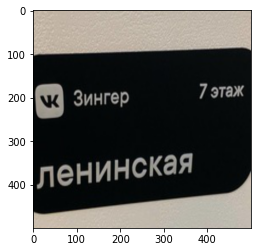

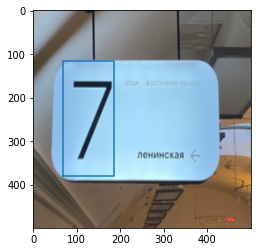

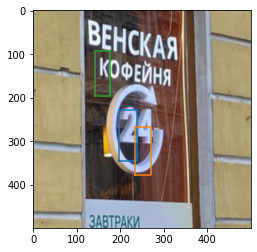

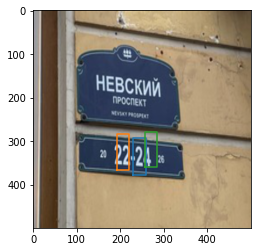

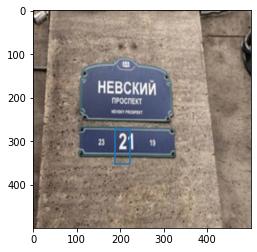

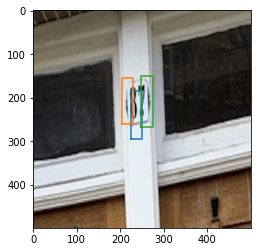

In [66]:
idx = 5
need_classification_mask = False
need_nms = True
need_boxes = True
need_centers_mask=False
need_true_centers_mask = False
model.eval()
for i in range(1, 7):
  img = Image.open(f'/content/drive/MyDrive/real_images_test/{i}-scaled.jpg')
  sample = Compose([ToTensor(), Resize((500, 500))])(img)
  # plt.imshow(sample.permute(1, 2, 0))
  sample = sample.to(device)
  with torch.no_grad():
    # sample = dataset[idx][0][0].to(device)
    predicts = model(sample.unsqueeze(0))[0].cpu().detach()

  image = sample.cpu().detach().permute(1, 2, 0)
  w, h, _ = image.shape

  sigmoid = nn.Sigmoid()
  probs = sigmoid(torch.flatten(predicts[0])).detach().cpu().numpy()
  c_xs = (sigmoid(torch.flatten(predicts[1])) * w).detach().cpu().numpy()
  c_ys = (sigmoid(torch.flatten(predicts[2])) * h).detach().cpu().numpy()
  ws = torch.exp(torch.flatten(predicts[3])).detach().cpu().numpy()
  hs = torch.exp(torch.flatten(predicts[4])).detach().cpu().numpy()

  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.imshow(image)
  w_step = w / 16
  h_step = h / 16
  import matplotlib
  for_alphas = sigmoid(predicts[0])
  if need_classification_mask:
      for i in np.arange(0, h, h_step):
          for j in np.arange(0, w, w_step):
              rect = matplotlib.patches.Rectangle((j, i), w_step, h_step, linewidth=2, alpha = for_alphas[int(i / h_step)][int(j / w_step)].item())
              ax.add_patch(rect)

  if need_centers_mask:
      for i in np.arange(0, h, h_step):
          for j in np.arange(0, w, w_step):
              if for_alphas[int(i / h_step)][int(j / w_step)].item() < 0.8:
                  continue
              c_x, c_y = j + w_step / 2, i + h_step / 2
              plt.plot([c_x, c_xs[int(j / w_step)]], [c_y, c_ys[int(i / h_step)]])
              
  if need_true_centers_mask:
      sign_target, c_xs_target, c_ys_target, _, _ = dataset.target_masks[idx].to_dense()
      c_xs_2 = (sigmoid(predicts[1]) * 500).detach().cpu().numpy()
      c_ys_2 = (sigmoid(predicts[2]) * 500).detach().cpu().numpy()
      for i in np.arange(0, h, h_step):
          for j in np.arange(0, w, w_step):
              if not sign_target[int(i / h_step)][int(j / w_step)]:
                  continue
              plt.plot([c_xs_target[int(i / h_step)][int(j / w_step)] * w, j + w_step / 2], [c_ys_target[int(i / h_step)][int(j / w_step)] * h, i + h_step / 2])
              
              
  if need_nms:
      scores = torch.from_numpy(probs)
      points = torch.stack([torch.from_numpy(c_xs - ws / 2), 
                            torch.from_numpy(c_ys - hs / 2), 
                            torch.from_numpy(c_xs + ws / 2), 
                            torch.from_numpy(c_ys + hs / 2)], dim=1)
      indices = nms(points, scores, 0.1)
      scores = scores[indices]
      indices = indices[scores > 0.8]
      c_xs = c_xs[indices]
      c_ys = c_ys[indices]
      ws = ws[indices]
      hs = hs[indices]
      
      
  if need_boxes:
      if not isinstance(c_xs, list):
          c_xs, c_ys, ws, hs = [c_xs], [c_ys], [ws], [hs]
      for c_x, c_y, w, h in zip(c_xs, c_ys, ws, hs):
          xs = [c_x - w / 2, c_x + w / 2, c_x + w / 2, c_x - w / 2, c_x - w / 2]
          ys = [c_y + h / 2, c_y + h / 2, c_y - h / 2, c_y - h / 2, c_y + h / 2]
          plt.plot(xs, ys)

Test evaluation

In [13]:
parsed_targets = mat_to_dataset('../input/street-view-house-numbers/test_digitStruct.mat')

Loading 13067 / 13068.
13068 records loaded.


In [14]:
!rm ../input/street-view-house-numbers/test/test/.Rhistory

In [15]:
dataset = DetectionDataset('../input/street-view-house-numbers/test', parsed_targets, mode='test')

100%|██████████| 13068/13068 [06:48<00:00, 32.02it/s]


In [16]:
dataloader = DataLoader(dataset, batch_size=20, shuffle=False)

In [18]:
def iou_precision_recall_for_image(predicts, targets):
  res = []
  for i, left in enumerate(targets):
    res.append([])
    for right in predicts:
      iou_score = iou(left, right)

      numerator = left.intersection(right).area
      precision_denominator = right.area
      recall_denominator = left.area

      res[i].append((iou_score, numerator / precision_denominator, numerator / recall_denominator))
      
  return list(zip(*list(map(lambda scores: max(scores, key=lambda x: x[0],  default=(0, 0, 0)), res))))
  

In [19]:
from shapely.geometry import box

bar = tqdm(dataloader)

model.eval()
w, h = 500, 500
all_preds = []
all_targets = []

ious = []
precisions = []
recalls = []
for xs, ys in bar:
  samples = xs.squeeze(1).to(device)
  masks   = ys.squeeze(1).to(device)

  with torch.no_grad():
    predicts = model(samples)

  for tgt, pred in zip(masks, predicts):
    probs, c_xs, c_ys, ws, hs = activate_result(pred)

    targets, points_targets = postprocess_target_tensor(tgt)
    scores, points, c_xs, c_ys, ws, hs = postprocessing(probs, c_xs, c_ys, ws, hs)

    all_preds.append({
        'boxes': points,
        'scores': scores,
        'labels': torch.ones(scores.shape)
    })

    all_targets.append({
        'boxes': points_targets,
        'labels': targets
    })

    rects = list(map(lambda x: box(*x), points))
    rects_targets = list(map(lambda x: box(*x), points_targets))

    iou_scores, precision_scores, recall_scores = iou_precision_recall_for_image(
        rects, rects_targets
    )

    ious.append(np.array(iou_scores).mean())
    precisions.append(np.array(precision_scores).mean())
    recalls.append(np.array(recall_scores).mean())

100%|██████████| 654/654 [09:00<00:00,  1.21it/s]


In [20]:
print(f"IOU: {np.array(ious).mean()}\nPrecision: {np.array(precisions).mean()}\nRecall: {np.array(recalls).mean()}")

IOU: 0.5870078010138026
Precision: 0.7170928000123575
Recall: 0.7439090418117843


In [21]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 7.8 MB/s 


In [22]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

In [23]:
metric = MeanAveragePrecision(class_metrics=False)
metric.update(all_preds, all_targets)
pprint(metric.compute())

{'map': tensor(0.2009),
 'map_50': tensor(0.5724),
 'map_75': tensor(0.0838),
 'map_large': tensor(0.2772),
 'map_medium': tensor(0.0928),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.),
 'mar_1': tensor(0.1658),
 'mar_10': tensor(0.3183),
 'mar_100': tensor(0.3183),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.4067),
 'mar_medium': tensor(0.1926),
 'mar_small': tensor(0.)}
